Consider a random variable $X$ with distribution $p(x)$ given by:
$$ p(x) = \begin{cases}
\frac{1}{4x^2} & |x| > 1\\
\frac{1}{4} & |x| \leq 1
\end{cases} \qquad x \in \mathbb{R}$$

To generate samples from $p(x)$ we use the *inverse transform method*, that is we generate uniform samples inside a domain $D$ we are interested in, and transform them into samples from $p(x)$ by using the inverse of its Cumulative Distribution Function. So, we need to invert:

$$ \int_{-\infty}^{x} p(x') {\rm d}x' = z \label{eqn:int}\tag{1} $$

To evaluate the integral, we need to distinguish $3$ cases:

1. If $x < -1$, then (\ref{eqn:int}) becomes:
$$ \int_{-\infty}^{x} \frac{1}{4x^2} {\rm d}x = -\frac{1}{4x} \Big|_{-\infty}^{x} = - \frac{1}{4x} = z \Rightarrow x = -\frac{1}{4z} $$
As $x < -1$, $-1/(4x) = z < 1/4$.

2. If $-1 \leq x \leq 1$, then (\ref{eqn:int}) becomes:
$$ -\frac{1}{4x}\Big|_{-\infty}^{1} + \int_{-1}^x \frac{1}{4} {\rm d}x = \frac{1}{4} + \frac{1}{4} (x+1) = z \Rightarrow x = 4z - 2$$
Moreover, $-1 \leq x \leq 1$ implies $1/4 \leq (x+2)/4 \leq 3/4$ and so $1/4 \leq z \leq 3/4$.

3. Finally, if $x > 1$ we have:
$$ \frac{1}{4} + \frac{1}{2} + \int_1^x \frac{1}{4x^2} {\rm d}x = \frac{3}{4} - \frac{1}{4x} \Big|_{1}^{x} = 1- \frac{1}{4x} = z \Rightarrow x= \frac{1}{4(1-z)} $$
As $x > 1$, $1-1/(4x) = z > 3/4$

Summarizing:
$$ x = \begin{cases}
-\frac{1}{4z} & z < \frac{1}{4}\\
4z -2 & \frac{1}{4} \leq z \leq \frac{3}{4}\\
\frac{1}{4(1-z)} & z > \frac{3}{4}
\end{cases} \qquad z \in (0,1) $$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def inv_transform(z): #vectorize with numpy for better performance
    cond1 = z < 1/4
    cond2 = np.logical_and(z <= 3/4, np.logical_not(cond1))
    cond3 = z > 3/4
    
    case1 = np.where(cond1, -1./(4*z), z)
    case2 = np.where(cond2, 4*z-2, case1)
    case3 = np.where(cond3, 1/(4*(1-z)), case2)

    return case3

In [2]:
num_samples = 10000
samples = np.random.uniform(size=num_samples)

%timeit a = inv_transform(samples) #1000 times faster

185 µs ± 390 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [3]:
#Comparison with usual python function

def inv_transform_scalar(z):
    if z < 1/4:
        return -1/(4*z)
    elif z <= 3/4:
        return 4*z - 2
    else:
        return 1/(4*(1-z))

In [4]:
#%timeit b = np.array([inv_transform_scalar(z) for z in samples])

In [5]:
#a = inv_transform(samples)
#b = np.array([inv_transform_scalar(z) for z in samples])
#np.all(a == b) #it works

Let $Y$ be the random variable with Cauchy Distribution:
$$ Y \sim p(Y) = \frac{1}{\pi(1+Y^2)} $$
We suppose that $Y_n$, which is the rescaled sum of $n$ random variables each following the distribution $p(x)$ defined above, distributes the same as $Y$. We wish to find explicitly the normalization required, splitting it in a common factor and a power of $n$:

$$ Y_n = \frac{\gamma S_n}{n^\beta} $$

Intuitively, we expect $\beta$ to be close to $1$ (as it happens in the CLT), and so we define $\beta = 1+\alpha$ and $s= S_n/n$ so that:

$$ Y_n = \frac{\gamma}{n^\alpha} s $$

Finally, we call $\delta = \gamma/n^\alpha$, so that:
$$ Y_n = \delta s $$
So that it will be easier to make a fit. We deduce the distribution of $s$ with a change of random variables:

$$ p(s) = p(Y) \frac{{\rm d}Y}{{\rm{d}s}} = \frac{\delta}{\pi(1+\delta^2 s^2)}$$

First, we choose a $n$, produce many samples of $s$, and fit their distribution with the expression for $p(s)$, leading to an estimate of $\delta$. By repeating this process for different values of $n$, we will be able to fit $\delta = \gamma/n^\alpha$ and find $\alpha$ and $\gamma$.

In [6]:
from scipy.optimize import curve_fit

def dist_s(s, delta):
    return delta / (np.pi * (1 + np.square(delta * s)))

num_samples = 100000
def find_delta(N, ax = None, show_plot=True):
    #generate num_samples of sums of N variables
    uniform_samples = np.random.uniform(size=(num_samples, N))
    p_samples = inv_transform(uniform_samples)
    
    s_samples = np.sum(p_samples, axis=1) / N
        
    if show_plot:
        if ax == None:
            fig, ax = plt.subplots()
        ys, bins, _ = ax.hist(s_samples, 1000, range=(-10,10), density=True, label="Samples", alpha=.7)
        ax.set_title("N = {}".format(N))
        ax.set_xlabel("s")
        ax.set_ylabel("pdf")
    else:
        ys, bins = np.histogram(s_samples, 1000, range=(-10, 10), density=True)
    
    centerbins = (bins[1:] + bins[:-1])/2
    popt, pcov = curve_fit(dist_s, centerbins, ys)
    delta = popt[0]
    deltaerr = np.sqrt(np.diag(pcov)[0])
    
    if show_plot:
        xs = np.linspace(-10, 10, 100)
        ax.plot(xs, dist_s(xs, *popt), '--r', label="Fit")
        plt.legend()
    
    print(delta, deltaerr)
    
    return (delta, deltaerr)
   
    

In [7]:
find_delta(10, show_plot=False)

1.2965560197554158 0.0038352466960235314


(1.2965560197554158, 0.0038352466960235314)

In [8]:
#compute delta at various N
Ns = [5, 50, 500, 1000]

deltas = [find_delta(n, show_plot=False)[0] for n in Ns]

1.2483402401327213 0.004382222167020101
1.33493899855975 0.003807505659440816
1.3313614733803678 0.00373474232082118
1.3370761888138842 0.0037985959565881708


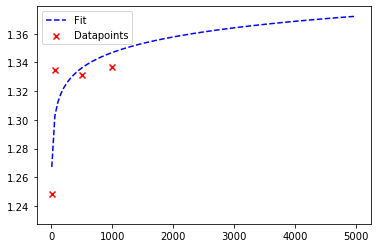

In [9]:
def delta_func(n, gamma, alpha):
    return gamma / (n**alpha)

(gamma, alpha), pcov = curve_fit(delta_func, Ns, deltas)

xs = np.linspace(5, 5000, 100)
plt.scatter(Ns, deltas, marker='x', c='r', label='Datapoints')
plt.plot(xs, delta_func(xs, gamma, alpha), '--b', label='Fit')
plt.legend()
plt.show()

In [10]:
(gammaerr, alphaerr) = np.sqrt(np.diag(pcov))
print("gamma = {:.4f} +- {:.4f}".format(gamma, gammaerr))
print("alpha = {:.4f} +- {:.4f}".format(alpha, alphaerr))

gamma = 1.2439 +- 0.0338
alpha = -0.0115 +- 0.0052
